# Setup

Collab specific stuff:

In [6]:
running_colab = False

In [7]:
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    logs_directory = 'drive/MyDrive/summaries'
    !pip install -r "drive/MyDrive/requirements.txt"
else:
    logs_directory = 'summaries'

Imports

In [26]:
import time
import gym_2048
from tensorforce import Agent, Environment
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Functions

# Plotting utils

In [14]:
# fonction pour ranger en ordre croissant un dico dans le but de le plotter avec plt
def sort_dico(dico):
    dico_sorted={}
    for k,v in dict(sorted(dico.items())).items():
        k_str = str(k)
        dico_sorted[k_str] = v

    return dico_sorted

In [15]:
# fonction pour plotter la distribution des scores et des max tiles
# à utiliser avec la fonction de test 'test_agent' et ce qu'elle retourne
# dico_sorted = sort_dico(dico_max_tiles_distribution)
# rewards = liste_score

def plot_metrics(dico_sorted,rewards):
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Max tile distribution')
    plt.bar(*zip(*dico_sorted.items()))

    plt.subplot(1, 2, 2)
    plt.title('Score distribution')
    sns.histplot(rewards, kde=True)

    print(f'Mean score over the test: {np.mean(rewards)}')
    print(f'Median score over the test: {np.median(rewards)}')
    print(f'Std score over the test: {np.std(rewards)}')
    print(f'Max tile over the test: {max([int(bins) for bins in dico_sorted.keys()])}')

# Useful code snippets

Render "beautiful" 2048 grid:

`imshow(environment._environment.environment.render(mode="rgb_array"))`

Illegal move reward:

`environment._environment.environment.set_illegal_move_reward(-10)`

Log2 reward:

`log2_reward = reward if reward <= 0 else np.log2(reward)`

Show TensorBoard graphs:

`%tensorboard --logdir summaries` (with parameter `summarizer=dict(directory='summaries')` in the `Agent.create()` method)

# Training

In [9]:
def train_agent(params, print_freq, file_name):
    ''' Function creating environment & agent based on params dict. 
    num_episodes defines how many episodes agent will train & print_freq defines 
    printing frequency. 
    Function will create dict of metrics & dict of params used in function & both
    will be saved as a csv with file_name'''

    # create a 2048 environment
    environment = Environment.create(
        environment = 'gym'
        , level = '2048-v0'
        , max_episode_timesteps = params['max_episode_timesteps']
    )

    # create an agent
    agent = Agent.create(
        agent = 'dqn'
        , environment = environment
        , **params['agent_hyperparams']
        , summarizer = dict(directory=logs_directory
                            , summaries=[
                                "regularization-loss"
                                , "loss"
                                , "episode-length"
                                , "episode-reward"
                                , "objective-loss"
                                , "reward"
                                , "update-return"
                            ]
                           )
    )

    # instantiate lists to record global training metrics
    max_tiles = []
    scores = []
    updates = []
    valid_moves = []
    run_time = []
    start_training_time = time.time()

    for episode in range(params['num_episodes']):
        state = environment.reset()
        terminal = False

        #Checking metrics while training
        state_freeze = state.copy()
        num_updates = 0
        num_moves = 0
        invalid_moves = 0
        start_episode_time = time.time()

        while not terminal:
            #Core
            action = agent.act(states=dict(state=state,  action_mask=environment._environment.environment.get_invalid_moves()))
            state, terminal, reward = environment.execute(actions=action)
            log2_reward = reward if reward <= 0 else np.log2(reward)
            num_updates += agent.observe(terminal=terminal, reward=log2_reward)

            #Number of moves
            num_moves += 1

            #Number of invalid moves
            if (state == state_freeze).all():
                invalid_moves += 1
            state_freeze = state.copy()

        # Storing score and max tile
        max_tiles.append(environment._environment.environment.Matrix.max())
        scores.append(environment._environment.environment.score)
        updates.append(num_updates)
        valid_moves.append(num_moves)
        run_time.append(round(time.time() - start_episode_time,2))

        if episode % print_freq == 0:
            print('Episode {}: score = {}, terminal = {}, updates={}, max_tile={}, valid_moves={}, invalid_moves={}, seconds={}'\
                  .format(episode, environment._environment.environment.score , terminal, num_updates, max_tiles[-1], num_moves-invalid_moves, invalid_moves, round(time.time() - start_episode_time,2)))
        
    metrics_dict = {
        'max_tiles': max_tiles
        , 'scores': scores
        , 'updates': updates
        , 'valid_moves': valid_moves
        , 'run_time' : run_time
    }
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_path = f'training_runs/{file_name}_metrics.csv'
    metrics_df.to_csv(metrics_path)
    
    params_path = f'training_runs/{file_name}_params.json'
    with open(params_path, 'w') as fp:
        json.dump(params, fp)
    
    environment.close()
    
    return (metrics_df, params, agent)

In [10]:
agent_hyperparams_dict = {
    'max_episode_timesteps': 1000 # Maximum steps allowed in episode. This hyper-param is for environment
    , 'batch_size': 16
    , 'update_frequency': 4
    , 'learning_rate': 0.001
    , 'discount': 0.8
    , 'memory': 30000
    , 'exploration': 0.1
    , 'target_sync_frequency': 4
    , 'horizon': 1
}

input_dict = {
    'max_episode_timesteps': 1000
    , 'num_episodes': 10
    , 'agent_hyperparams': agent_hyperparams_dict
}

In [11]:
metrics_df, params, agent = train_agent(input_dict, 1, 'test') # 1 : print frequency, 'test' : files name

Episode 0: score = 712.0, terminal = 1, updates=22, max_tile=64, valid_moves=95, invalid_moves=0, seconds=10.6
Episode 1: score = 636.0, terminal = 1, updates=21, max_tile=64, valid_moves=84, invalid_moves=0, seconds=1.29
Episode 2: score = 1016.0, terminal = 1, updates=28, max_tile=128, valid_moves=114, invalid_moves=0, seconds=1.87
Episode 3: score = 1080.0, terminal = 1, updates=29, max_tile=128, valid_moves=117, invalid_moves=0, seconds=2.16
Episode 4: score = 1644.0, terminal = 1, updates=40, max_tile=128, valid_moves=162, invalid_moves=0, seconds=2.73
Episode 5: score = 708.0, terminal = 1, updates=23, max_tile=64, valid_moves=94, invalid_moves=0, seconds=1.67
Episode 6: score = 3076.0, terminal = 1, updates=63, max_tile=256, valid_moves=255, invalid_moves=0, seconds=4.59
Episode 7: score = 424.0, terminal = 1, updates=17, max_tile=32, valid_moves=68, invalid_moves=0, seconds=1.26
Episode 8: score = 1164.0, terminal = 1, updates=32, max_tile=128, valid_moves=128, invalid_moves=0,

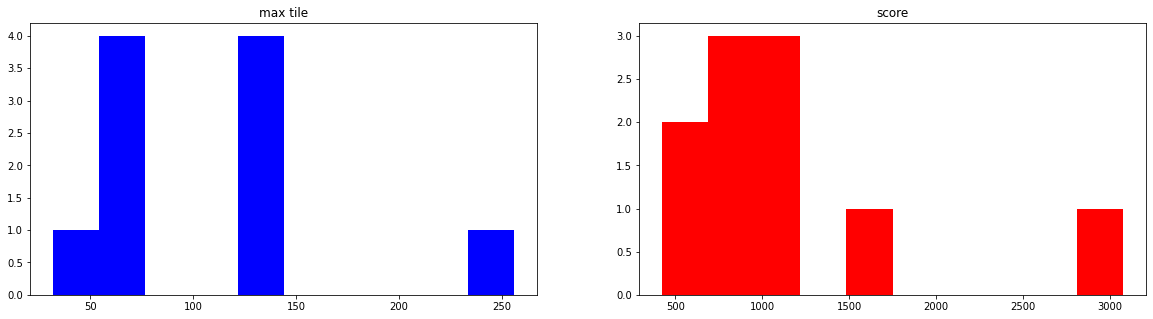

In [12]:
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(test_df[0].max_tiles, color = 'b')
ax1.set_title('max tile')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(test_df[0].scores, color = 'r')
ax2.set_title('score');

In [8]:
%tensorboard --logdir $logs_directory

# Testing

In [21]:
# Evaluate for n episodes
def test_agent(agent,n_episode):
    #definir l'env
    environment = Environment.create(environment = 'gym', level = '2048-v0', 
    max_episode_timesteps = 1000
    )
    n_episode = n_episode
    #dictionnaire pour obtenir la distribution des max tiles de chaque episode
    dico_max_tiles_distribution = {}
    # liste des score par episode
    liste_score=[]
    # dictionnaire pour récupérer la meilleure et la pire partie du test
    dico_best_worst_episode = {'Worst':[],'Best':[], 'Episode # Worst':[], 'Episode # Best':[]}

    for episode in range(n_episode):
        sum_rewards = 0.0
        states = environment.reset()
        list_states=[]
        internals = agent.initial_internals()
        terminal = False

        while not terminal:
            actions, internals = agent.act(
                states= {
                    "state":states,
                    "action_mask":environment._environment.environment.get_invalid_moves()},
                internals=internals,
                independent=True, deterministic=True
            )
            states, terminal, reward = environment.execute(actions=actions)
            matrix = environment._environment.environment.Matrix
            list_states.append(matrix.copy())
            sum_rewards += reward

        liste_score.append(sum_rewards)

        if sum_rewards >= max(liste_score):
            dico_best_worst_episode['Best'] = list_states
            dico_best_worst_episode['Episode # Best'] = episode
        elif sum_rewards <= min(liste_score):
            dico_best_worst_episode['Worst'] = list_states
            dico_best_worst_episode['Episode # Worst'] = episode

        dico_max_tiles_distribution.setdefault(environment._environment.environment.Matrix.max(),0)
        dico_max_tiles_distribution[environment._environment.environment.Matrix.max()] += 1

    return dico_best_worst_episode, liste_score, dico_max_tiles_distribution


In [22]:
results = test_agent(agent, 10)

Mean score over the test: 1138.0
Median score over the test: 1194.0
Std score over the test: 413.1295196424482
Max tile over the test: 128


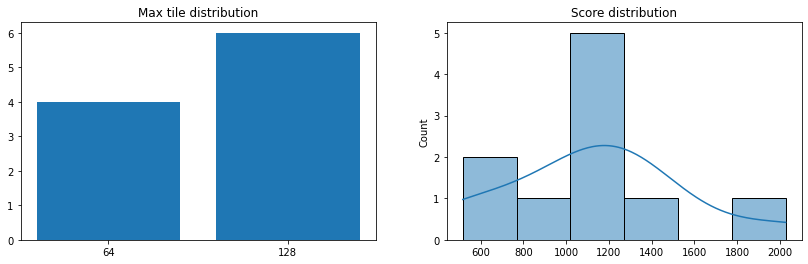

In [27]:
plot_metrics(sort_dico(results[2]), results[1])

In [16]:
test_df

(   max_tiles  scores  updates  valid_moves  run_time
 0         64   712.0       22           95     10.60
 1         64   636.0       21           84      1.29
 2        128  1016.0       28          114      1.87
 3        128  1080.0       29          117      2.16
 4        128  1644.0       40          162      2.73
 5         64   708.0       23           94      1.67
 6        256  3076.0       63          255      4.59
 7         32   424.0       17           68      1.26
 8        128  1164.0       32          128      2.21
 9         64   784.0       25          102      1.95,
 {'max_episode_timesteps': 1000,
  'num_episodes': 10,
  'agent_hyperparams': {'max_episode_timesteps': 1000,
   'batch_size': 16,
   'update_frequency': 4,
   'learning_rate': 0.001,
   'discount': 0.8,
   'memory': 30000,
   'exploration': 0.1,
   'target_sync_frequency': 4,
   'horizon': 1}},
 <tensorforce.agents.dqn.DeepQNetwork at 0x150f33d60>)